# Brain tumor image classification

In [1]:
# Basic utils
import pandas as pd
import numpy as np 
import os
import cv2
import PIL
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Traditional ML
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


# Tensorflow kears imports
import tensorflow as tf
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import legacy


# Data processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

seed = 123

# to ensure reprdusability
# Setting seed for consistent results
tf.keras.utils.set_random_seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

class_types = ['pituitary', 'notumor', 'meningioma', 'glioma']
n_types = len(class_types)

import warnings
warnings.filterwarnings('ignore')

/Users/mikkelpedersen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)

    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)

    return data_path, data_labels

In [3]:
# Setting up file paths for training and testing
USER_PATH = "/Users/mikkelpedersen/Desktop/project_vs_studio/ML projekter/Brain_images"
train_dir = USER_PATH + '/Training'
test_dir = USER_PATH + '/Testing'

# Getting data using above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


In [4]:
train_data = {'train_path_df':train_paths, 'train_labels_df':train_labels}
train_df = pd.DataFrame(train_data)


test_data = {'test_path_df':test_paths, 'test_labels_df':test_labels}
test_df = pd.DataFrame(test_data)

train_df, test_df

(                                          train_path_df train_labels_df
 0     /Users/mikkelpedersen/Desktop/project_vs_studi...         notumor
 1     /Users/mikkelpedersen/Desktop/project_vs_studi...       pituitary
 2     /Users/mikkelpedersen/Desktop/project_vs_studi...          glioma
 3     /Users/mikkelpedersen/Desktop/project_vs_studi...         notumor
 4     /Users/mikkelpedersen/Desktop/project_vs_studi...       pituitary
 ...                                                 ...             ...
 5707  /Users/mikkelpedersen/Desktop/project_vs_studi...      meningioma
 5708  /Users/mikkelpedersen/Desktop/project_vs_studi...          glioma
 5709  /Users/mikkelpedersen/Desktop/project_vs_studi...         notumor
 5710  /Users/mikkelpedersen/Desktop/project_vs_studi...         notumor
 5711  /Users/mikkelpedersen/Desktop/project_vs_studi...         notumor
 
 [5712 rows x 2 columns],
                                            test_path_df test_labels_df
 0     /Users/mikkelpede

In [5]:
def data_distribution(train_labels, test_labels):
    num_labels_train = train_labels.value_counts()
    num_labels_test = test_labels.value_counts()
    print(f'The number of labels in the traning set: {num_labels_train}')
    print(f'The number of labels in the traning set: {num_labels_test}')
    
    #countplots
    fig, ax = plt.subplots(1, 2, figsize=(7, 4))

    ax0order =['notumor', 'pituitary', 'meningioma', 'glioma']
    sns.countplot(data=train_df, x='train_labels_df', hue='train_labels_df', palette='rocket', ax=ax[0], order=ax0order)
    ax[0].set_title('Training set')
    ax[0].set_xticklabels(num_labels_train.index, rotation=45)
    for i, count in enumerate(num_labels_train.values):
        ax[0].text(i, count + 4, str(count), ha='center', va='center')

    ax1order = ['notumor', 'meningioma', 'pituitary', 'glioma']
    sns.countplot(data=test_df, x='test_labels_df', hue='test_labels_df', palette='rocket', ax=ax[1], order=ax1order)
    ax[1].set_title('Test set')
    ax[1].set_xticklabels(num_labels_train.index, rotation=45)
    for i, count in enumerate(num_labels_test.values):
        ax[1].text(i, count + 4, str(count), ha='center', va='top')

    plt.tight_layout()
    plt.show()

The number of labels in the traning set: train_labels_df
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64
The number of labels in the traning set: test_labels_df
notumor       405
meningioma    306
pituitary     300
glioma        300
Name: count, dtype: int64


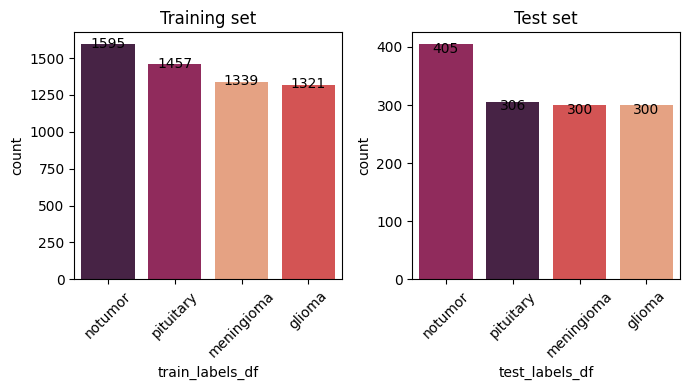

In [6]:
data_distribution(train_df['train_labels_df'], test_df['test_labels_df'])

In [7]:
def show_img(path, index):
    im = load_img(path[index], target_size=(300, 300))
    im = img_to_array(im)

    #Resahape image
    im = np.expand_dims(im, axis=0)
    print(f'x resahpoed: {im.shape}')

    #Normalize tensor
    im /= np.max(im)

    im = array_to_img(im[0])
    display(im)

x resahpoed: (1, 300, 300, 3)


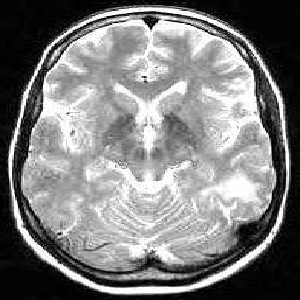

In [8]:
show_img(train_paths, 3)

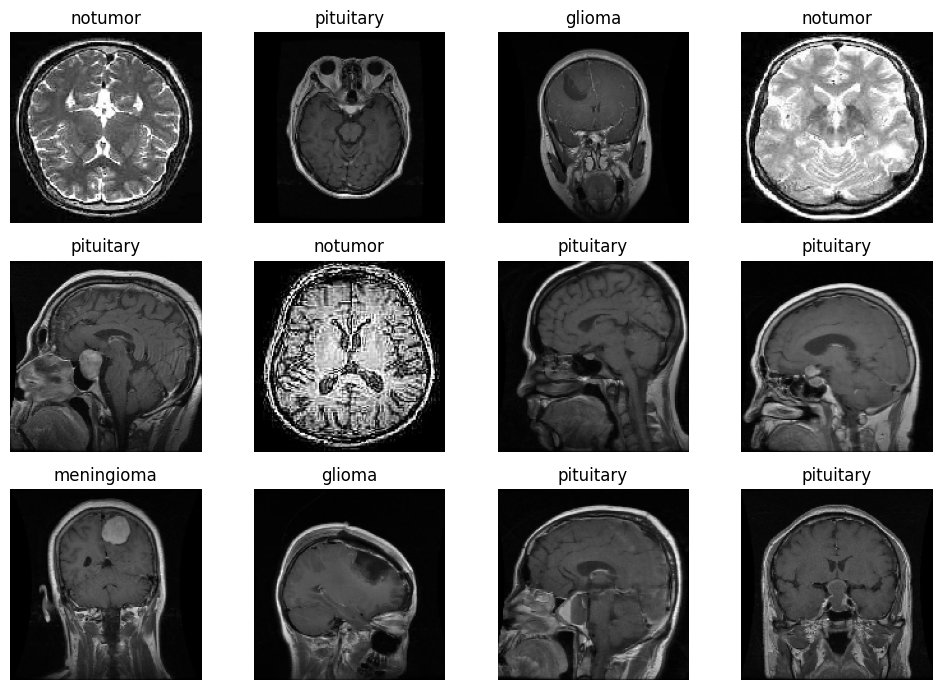

In [9]:

def show_images(train_paths, train_labels):
    fig, axes = plt.subplots(3, 4, figsize=(10, 7))  # Adjusted figsize for better visualization

    for i, ax in enumerate(axes.flat):
        if i < len(train_paths):
            image = load_img(train_paths[i], target_size=(150, 150))
            image = img_to_array(image)
            image /= np.max(image)
            image = array_to_img(image)
            ax.imshow(image)
            ax.set_title(train_labels[i])
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

show_images(train_paths[:12], train_labels[:12])

In [10]:
img_size = (150,150)
batch_size = 32

#Data argumentation and preprocessing

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85,1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0.15,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='nearest')

train_gen = train_datagen.flow_from_dataframe(train_df,
                                              x_col='train_path_df',
                                              y_col='train_labels_df',
                                              target_size=img_size,
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              seed=seed)
                                   
                                   
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(test_df,
                                            x_col='test_path_df',
                                            y_col='test_labels_df',
                                            target_size=img_size,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            seed=seed)

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [11]:
def visualize_augmentations(generator, num_images):
    fig, axes = plt.subplots(3, 4, figsize=(10, 10))
    images, labels = next(generator)
    for i in range(num_images):
        if i < len(generator):
            ax = axes.flat[i]
            ax.imshow(images[i])
            ax.set_title(train_labels[i])
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

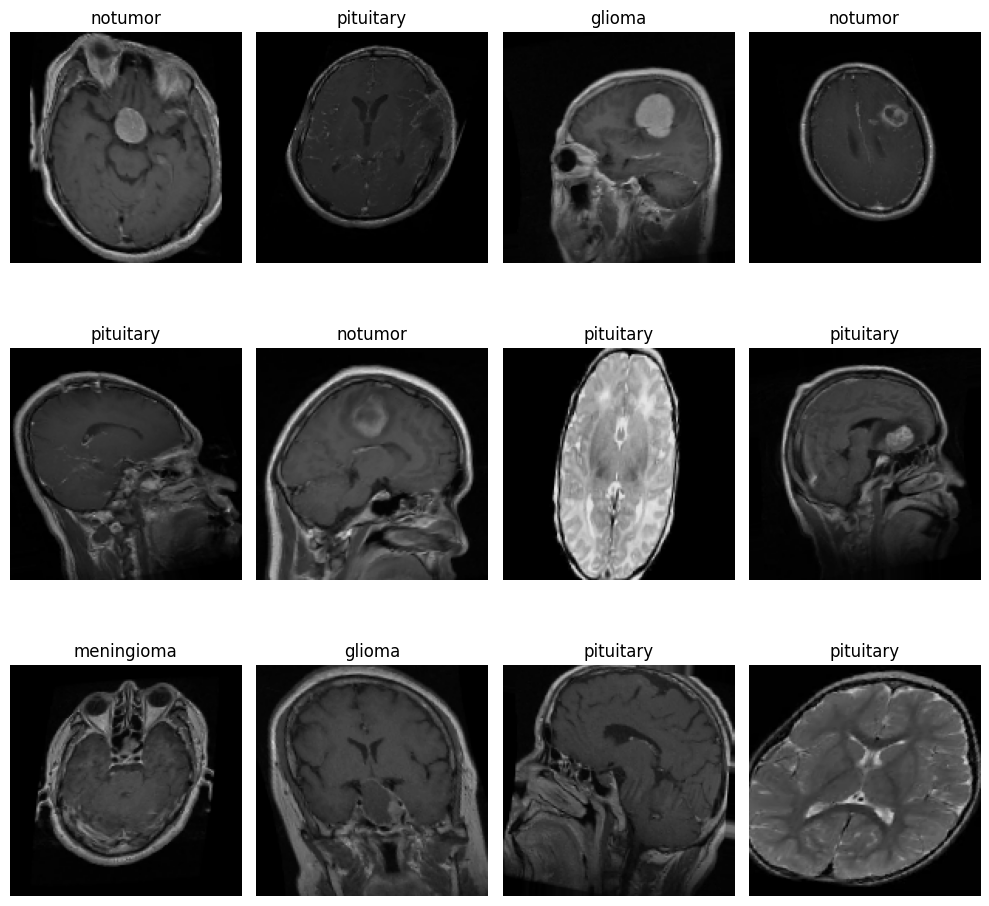

In [12]:
visualize_augmentations(train_gen, 12)

In [13]:
class_indeciss = train_gen.class_indices

print(f'This is the class indecies {class_indeciss}')

This is the class indecies {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [14]:
# values for traning 
image_shape = (img_size[0], img_size[1], 3)

epochs = 40

steps_per_epoch = train_gen.samples // batch_size

val_steps = test_gen.samples // batch_size

print(f'The image size: {image_shape}')
print(f'The amount of epochs: {epochs}')
print(f'the number of steps per epoch: {steps_per_epoch}')
print(f'The number of validation steps {val_steps}')

The image size: (150, 150, 3)
The amount of epochs: 40
the number of steps per epoch: 178
The number of validation steps 40


In [ ]:
model1 = tf.keras.models.Sequential()

model1.add(Conv2D(32, (2,2), activation='relu', input_shape=image_shape))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64, (2,2), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(128, (2,2), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(128, (2,2), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5, seed=seed))
model1.add(Dense(n_types, activation='softmax'))

print(model1.summary)

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

# Define your model
model1 = tf.keras.models.Sequential()

# Add convolutional and pooling layers
model1.add(Conv2D(32, (2, 2), activation='relu', input_shape=image_shape))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (2, 2), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (2, 2), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (2, 2), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output before feeding into Dense layers
model1.add(Flatten())  # Flatten the 3D output to 1D

# Add fully connected (Dense) layers
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))  # No 'seed' argument needed

# Output layer with 'n_types' classes and softmax activation
model1.add(Dense(n_types, activation='softmax'))

# Print model summary
model1.summary()

# Compile the model
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 149, 149, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 35, 35, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,304,100 (16.42 MB)

 Trainable params: 4,304,100 (16.42 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#stops 
model1_es = EarlyStopping(monitor='loss', patience=5, verbose=True)

#Model Training
model1_hist = model1.fit(train_gen,
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         validation_data=test_gen,
                         validation_steps=val_steps,
                         callbacks=[model1_es])

Epoch 1/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 106s 586ms/step - accuracy: 0.5245 - loss: 1.0387 - val_accuracy: 0.6617 - val_loss: 0.9242
Epoch 2/40
  1/178 ━━━━━━━━━━━━━━━━━━━━ 38s 217ms/step - accuracy: 0.8750 - loss: 0.4537

2024-10-18 20:45:04.077895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8750 - loss: 0.2281 - val_accuracy: 0.7742 - val_loss: 0.3204
Epoch 3/40


2024-10-18 20:45:04.394636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 37s 203ms/step - accuracy: 0.7605 - loss: 0.6000 - val_accuracy: 0.7617 - val_loss: 0.6575
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - accuracy: 0.7188 - loss: 0.4121 - val_accuracy: 0.8387 - val_loss: 0.2248
Epoch 5/40


2024-10-18 20:45:41.759614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-18 20:45:41.806004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 193ms/step - accuracy: 0.7996 - loss: 0.4918 - val_accuracy: 0.8141 - val_loss: 0.4526
Epoch 6/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - accuracy: 0.8438 - loss: 0.2520 - val_accuracy: 0.8387 - val_loss: 0.1498
Epoch 7/40


2024-10-18 20:46:17.261214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-18 20:46:17.308652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 195ms/step - accuracy: 0.8350 - loss: 0.4326 - val_accuracy: 0.8398 - val_loss: 0.4006
Epoch 7: early stopping


In [19]:
print(model1_hist.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


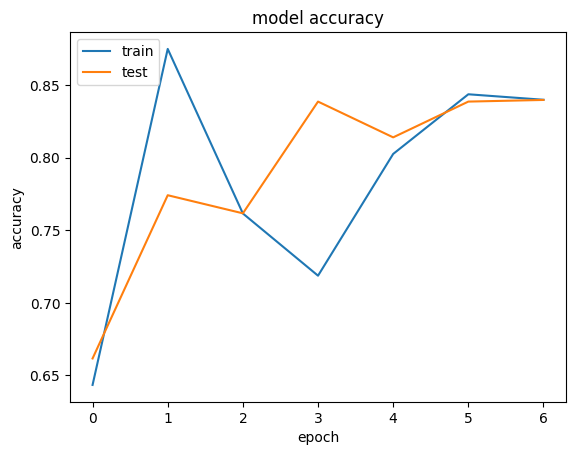

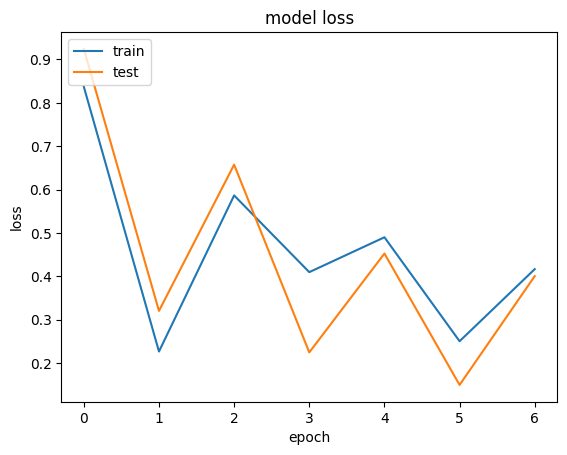

In [20]:
plt.plot(model1_hist.history['accuracy'])
plt.plot(model1_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model1_hist.history['loss'])
plt.plot(model1_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()